In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import math
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px

C = 3E8

In [3]:
def backprojection(pt_clouds, 
                   voxel_grid, 
                   start_gate, 
                   end_gate, 
                   bin_width, 
                   hists, 
                   voxel_params,
                   xlim, 
                   ylim,
                   zlim,
                   thresh = np.nan):
        """
        pt_clouds : List of length num_frames. Each entry contains np array [12, 12, 3]  
        voxel_grid: [num_voxels, 3]
        start_gate: scalar
        end_gate  : scalar
        bin_width : scalar
        hists     : List of length num_frames. Each entry contains np array [12, 12, numBins]
        """
        # === reshape hists and point clouds === #
        hists = [hist.reshape(64, -1) for hist in hists]
        pt_clouds = [pt_cloud.reshape(64, 3) for pt_cloud in pt_clouds]
        
        # === Extract voxel params === #
        num_x, num_y, num_z = voxel_params[0:3]
        num_voxels = voxel_grid.shape[0]

        # === Extract other parameters === #
        num_hists = len(hists)
        if np.isnan(thresh):
            thresh = bin_width * C

        # === Backprojection === #
        volume = np.zeros((num_voxels, 1))
        for k in range(num_hists):
            cur_pt_cloud = pt_clouds[k]
            for i, cur_pixel in enumerate(cur_pt_cloud):
                dists = np.linalg.norm(voxel_grid - cur_pixel.reshape(1, 3), axis=1).reshape(-1, 1)
                for j in range(start_gate, end_gate):
                    cur_radius = j * bin_width * C / 2
                    mask = np.abs(dists - cur_radius) < thresh
                    volume += hists[k][i, j] * mask

        volume = volume.reshape(num_x, num_y, num_z, order="C")

        # === filtering step === #
        volume_filter = filter_volume(volume, num_x, num_y)
        volume_filter = np.transpose(volume_filter, [2, 1, 0])
        volume_filter = np.flip(volume_filter, axis=(1, 2))

        # === Determine plotting === #
        x_tick_labels = np.linspace(0, num_x-1, 3)
        y_tick_labels = np.linspace(0, num_y-1, 3)
        z_tick_labels = np.linspace(0, num_z-1, 3)

        x_tick_vals = np.flip(np.linspace(xlim[0], xlim[1], 3))
        y_tick_vals = np.flip(np.linspace(ylim[0], ylim[1], 3))
        z_tick_vals = np.linspace(zlim[0], zlim[1], 3)

        axis_labels = [x_tick_labels, y_tick_labels, z_tick_labels]
        axis_vals = [x_tick_vals, y_tick_vals, z_tick_vals]

        return volume_filter, axis_labels, axis_vals


def filter_volume(volume: np.ndarray, num_x, num_y) -> np.ndarray:
        volume_unpadded = 2 * volume[:, :, 1:-1] - volume[:, :, :-2] - volume[:, :, 2:]
        zero_pad = np.zeros((num_x, num_y, 1))
        volume_padded = np.concatenate([zero_pad, volume_unpadded, zero_pad], axis=-1)
        return volume_padded



In [4]:

# PIXEL_SIZE = [16.8e-6, 38.8e-6]  # Pixel size in meters
PIXEL_SIZE = [41.4e-6, 41.1e-6]
FOCAL_LENGTH = 400e-6  # Focal length in meters

C = 3e8  # Speed of light in meters per second

BIN_RESOLUTION = 100e-12
# FOV_X = 41  # Field of view in x-direction [deg]
# FOV_Y = 52  # Field of view in y-direction [deg]

FOV_X = 45
FOV_Y = 45

In [5]:
FOV_X = 45
FOV_Y = 45
MIN_RESOLUTION = 37e-3
CNH_SUBSAMPLE = 2
BIN_RESOLUTION = CNH_SUBSAMPLE * MIN_RESOLUTION

In [6]:

def extract_point_cloud_interpolated(hists: np.ndarray, N: int) -> np.ndarray:
    fx, fy = FOCAL_LENGTH / PIXEL_SIZE[0] * 3, FOCAL_LENGTH / PIXEL_SIZE[1] * 2
    cx, cy = hists.shape[1] / 2, hists.shape[0] / 2
    points = []
    H, W, _ = hists.shape
    for i in range(H):
        for j in range(W):
            bin_index = np.argmax(hists[i, j])
            # TODO: why / 2?
            t = bin_index * BIN_RESOLUTION / 2
            depth = (C * t) / 2
            for u in range(N):
                for v in range(N):
                    x_sub = j + (v + 0.5) / N
                    y_sub = i + (u + 0.5) / N
                    X = (x_sub - cx) * depth / fx
                    Y = (y_sub - cy) * depth / fy
                    Z = depth
                    points.append([X, Y, Z])
    return np.array(points)

In [7]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from cc_hardware.utils.manager import Manager
from cc_hardware.utils.file_handlers import PklReader
from cc_hardware.utils import register_cli, run_cli
from cc_hardware.utils import get_logger

In [8]:
"""Datasets and data processing utils for modeling"""

from pathlib import Path

import numpy as np

import torch
from torch.utils.data import Dataset

from cc_hardware.utils.file_handlers import PklReader


class HistogramDataset(Dataset):
    """
    Histogram dataset for model training and analysis. Contains a corresponding list of inputs (histograms) and targets.
    Can manipulate inputs and targets without affecting raw data.
    """

    def __init__(self, pkl_path: Path = None, rolling_window=1, predict_magnitude: bool = False, merge: bool = False):
        """
        Initializes the HistogramDataset.

        Args:
        pkl_path (Path): Path to the PKL file containing the histogram data.
        rolling_window (int): Number of samples to use for rolling mean smoothing. This is applied to raw inputs. Default is 1.
        predict_magnitude (bool): Whether to predict the magnitude of the position. 
            Computes Euclidean distance from the origin. Default is False.
        merge (bool): Whether to merge the input and target data. Default is False.
        """
        if pkl_path is None:
            self.data = []
            self.inputs = []
            self.targets = []
            return

        self.data = PklReader.load_all(pkl_path)
        inputs = dict(
            histogram=[],
            position=[],
        )
        for d in self.data:
            if "has_masks" in d and not d["has_masks"]:
                d["position"] = [0, 0, 0]
                print("mask continue")
                continue
            if "histogram" in d:
                inputs["histogram"].append(torch.tensor(d["histogram"]))
            if "position" in d:
                pos = d["position"]
                inputs["position"].append(torch.tensor((pos["x"], pos["y"])))
            else:
                print("Warning: no position")
                inputs["position"].append(torch.tensor((0, 0)))
        
        if len(inputs["histogram"][0].shape) == 2:
            # single capture per location
            # reading input as list of location samples: (pixels, bins)
            # reading targets as list of location samples: ((x, y) position)
            self.raw_inputs = torch.stack(inputs["histogram"]).float()
            num_samples = self.raw_inputs.shape[0]
            width = np.sqrt(self.raw_inputs.shape[1]).astype(int)
            height = width
            bins = self.raw_inputs.shape[2]
            self.raw_inputs = torch.reshape(self.raw_inputs, (num_samples, width, height, bins))
            self.raw_targets = torch.stack(inputs["position"]).float()
        elif len(inputs["histogram"][0].shape) == 3:
            # multiple captures per location:
            # reading input as list of location samples: (captures per location, pixels, bins)
            # reading targets as list of location samples: ((x, y) position)
            self.raw_inputs = torch.stack(inputs["histogram"]).float()  # (locations, captures, pixels, bins)
            samples_per_location = inputs["histogram"][0].shape[0]
            if rolling_window != 1:
                sliding_mean = np.array(
                    [self.raw_inputs[:, j - rolling_window + 1: j + 1, :, :].mean(axis=1)
                        for j in range(rolling_window - 1, samples_per_location)
                    ]).swapaxes(0, 1)
                self.raw_inputs = torch.tensor(sliding_mean)
            samples_per_location = self.raw_inputs.shape[1]

            self.raw_inputs = torch.reshape(self.raw_inputs, 
                (self.raw_inputs.shape[0] * self.raw_inputs.shape[1], self.raw_inputs.shape[2], self.raw_inputs.shape[3]))
            num_samples = self.raw_inputs.shape[0]
            width = np.sqrt(self.raw_inputs.shape[1]).astype(int)
            height = width
            bins = self.raw_inputs.shape[2]
            self.raw_inputs = torch.reshape(self.raw_inputs, (num_samples, width, height, bins))
            self.raw_targets = torch.stack(inputs["position"], dim=0).float()  # (location samples, (x, y) position)
            self.raw_targets = torch.repeat_interleave(self.raw_targets, samples_per_location, dim=0)

        self.START_BIN = 0
        self.END_BIN = bins
        self.inputs = self.raw_inputs
        self.targets = self.raw_targets

        if predict_magnitude:
            self.targets = torch.linalg.norm(self.targets, dim=1, keepdim=True)

        if merge:
            self.inputs = self.inputs.sum(dim=(1), keepdim=True)

    def set_start_bin(self, start_bin: int):
        """
        Sets the start bin for the input data.
        """
        self.START_BIN = start_bin
        self.inputs = self.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]

    def set_end_bin(self, end_bin: int):
        """
        Sets the end bin for the input data.
        """
        self.END_BIN = end_bin
        self.inputs = self.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]

    def get_raw_bin_num(self):
        """
        Returns the number of bins in the raw input data (with no transformations applied).

        Returns:
            int: The number of bins in the raw input data.
        """
        return self.raw_inputs.shape[3]

    def get_bin_num(self):
        """
        Returns the number of bins in the input data.

        Returns:
            int: The number of bins in the input data.
        """
        return self.inputs.shape[3]
    
    def augment(self, factor: int, std_multiplier: float = 1.0):
        """
        Augments the dataset by repeating the inputs and targets a given number of times.

        Args:
            factor (int): The number of times to repeat the inputs and targets.
            std_multiplier (float): Number of standard deviations to generate augmented sample from.
        """
        std = self.inputs.std(dim=0)
        self.inputs = self.inputs.repeat_interleave(factor, dim=0)
        self.inputs += torch.normal(torch.zeros_like(self.inputs), std * std_multiplier)
        self.targets = self.targets.repeat_interleave(factor, dim=0)

    def get_mean_capture(self):
        """
        Gets the mean of all input captures in the dataset.

        Returns:
            torch.Tensor: The mean capture.
        """
        return self.inputs.mean(dim=0)
    
    def set_zero(self, zero: torch.Tensor):
        """
        Sets the empty capture of the dataset, subtracting it from all inputs.
        """
        self.inputs = self.inputs - zero
    
    def clip_negative(self):
        """
        Clips negative input values to zero.
        """
        self.inputs[self.inputs < 0] = 0

    def reset_transformations(self):
        """
        Resets the transformations applied to the dataset.
        """
        self.inputs = self.raw_inputs
        self.targets = self.raw_targets

    def invert(self):
        """
        Rotates input by 180 degrees.
        """
        self.inputs = torch.flip(self.inputs, dims=(1, 2))

    def interpolate_bins(self, factor: int):
        """
        Interpolates bins input by a factor
        """
        n = self.inputs.shape[0]
        h = self.inputs.shape[1]
        w = self.inputs.shape[2]
        b = self.inputs.shape[3]
        self.inputs = self.inputs.reshape(n, h * w, b)
        self.inputs = torch.nn.functional.interpolate(self.inputs, scale_factor=factor, mode="linear")
        self.inputs = self.inputs.reshape(n, h, w, b * factor)
        self.inputs = self.inputs / factor  # scale down to account for interpolation

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns: 
            int: The number of samples in the dataset
        """
        return len(self.targets)

    def __getitem__(self, idx):
        """
        Returns the item at index position (idx).

        Returns: 
            (torch.Tensor, torch.Tensor): The (input, target) at index position (idx)
        """
        return self.inputs[idx], self.targets[idx]
    
    def __add__(self, other):
        """
        Joins two datasets. Use only on datasets confirmed to contain data of the same dimension.
        """
        combined_dataset = HistogramDataset()
        combined_dataset.raw_inputs = torch.cat((self.raw_inputs, other.raw_inputs), dim=0)
        combined_dataset.raw_targets = torch.cat((self.raw_targets, other.raw_targets), dim=0)
        combined_dataset.START_BIN = self.START_BIN
        combined_dataset.END_BIN = self.END_BIN
        combined_dataset.inputs = combined_dataset.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]
        combined_dataset.targets = combined_dataset.raw_targets
        return combined_dataset




In [9]:
pkl_path = "../../datasets/robotics/localization/demo_arrow/capture_retro_mini_1.pkl"
dataset_1 = HistogramDataset(
    pkl_path,
    rolling_window=1
)

pkl_path = "../../datasets/robotics/localization/demo_arrow/zero.pkl"
dataset_zero = HistogramDataset(
    pkl_path,
    rolling_window=1
)

pkl_path = "../../datasets/robotics/localization/demo_arrow/first_bounce.pkl"
dataset_first_bounce = HistogramDataset(
    pkl_path,
    rolling_window=1
)

pkl_path = "../../datasets/robotics/localization/demo_arrow/debug.pkl"
dataset_debug = HistogramDataset(
    pkl_path,
    rolling_window=1
)

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_7038/2270627515.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  inputs["histogram"].append(torch.tensor(d["histogram"]))


In [10]:
dataset_1.raw_inputs.shape

torch.Size([1000, 8, 8, 16])

In [11]:
dataset_1.raw_targets.shape

torch.Size([1000, 2])

In [12]:
dataset_zero.inputs.shape

torch.Size([500, 8, 8, 16])

In [13]:
dataset_zero.inputs = dataset_zero.inputs[3:]

In [14]:
dataset_zero.inputs.shape

torch.Size([497, 8, 8, 16])

In [15]:
dataset_1.set_zero(dataset_zero.get_mean_capture())

In [16]:
dataset_1.clip_negative()

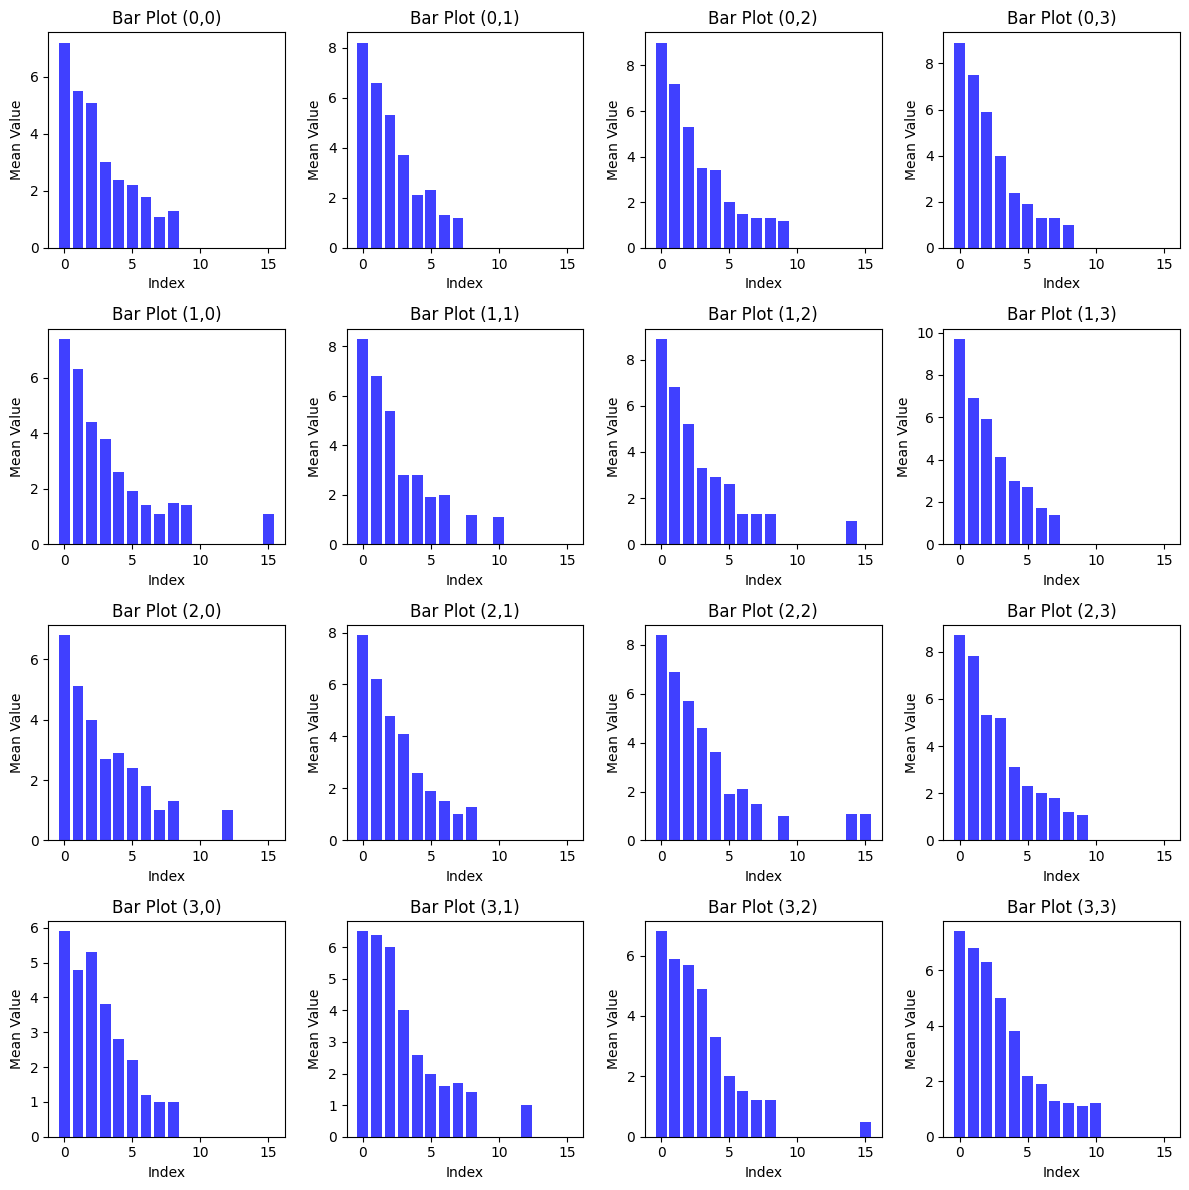

In [17]:
# Compute mean over the first dimension (n)
mean_tensor = dataset_zero.inputs[3]  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(16)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
        axes[i, j].bar(x, mean_tensor[i, j].numpy(), color='b', alpha=0.75)
        axes[i, j].set_title(f"Bar Plot ({i},{j})")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("Mean Value")
        # axes[i, j].set_yscale('log')

plt.tight_layout()
plt.show()

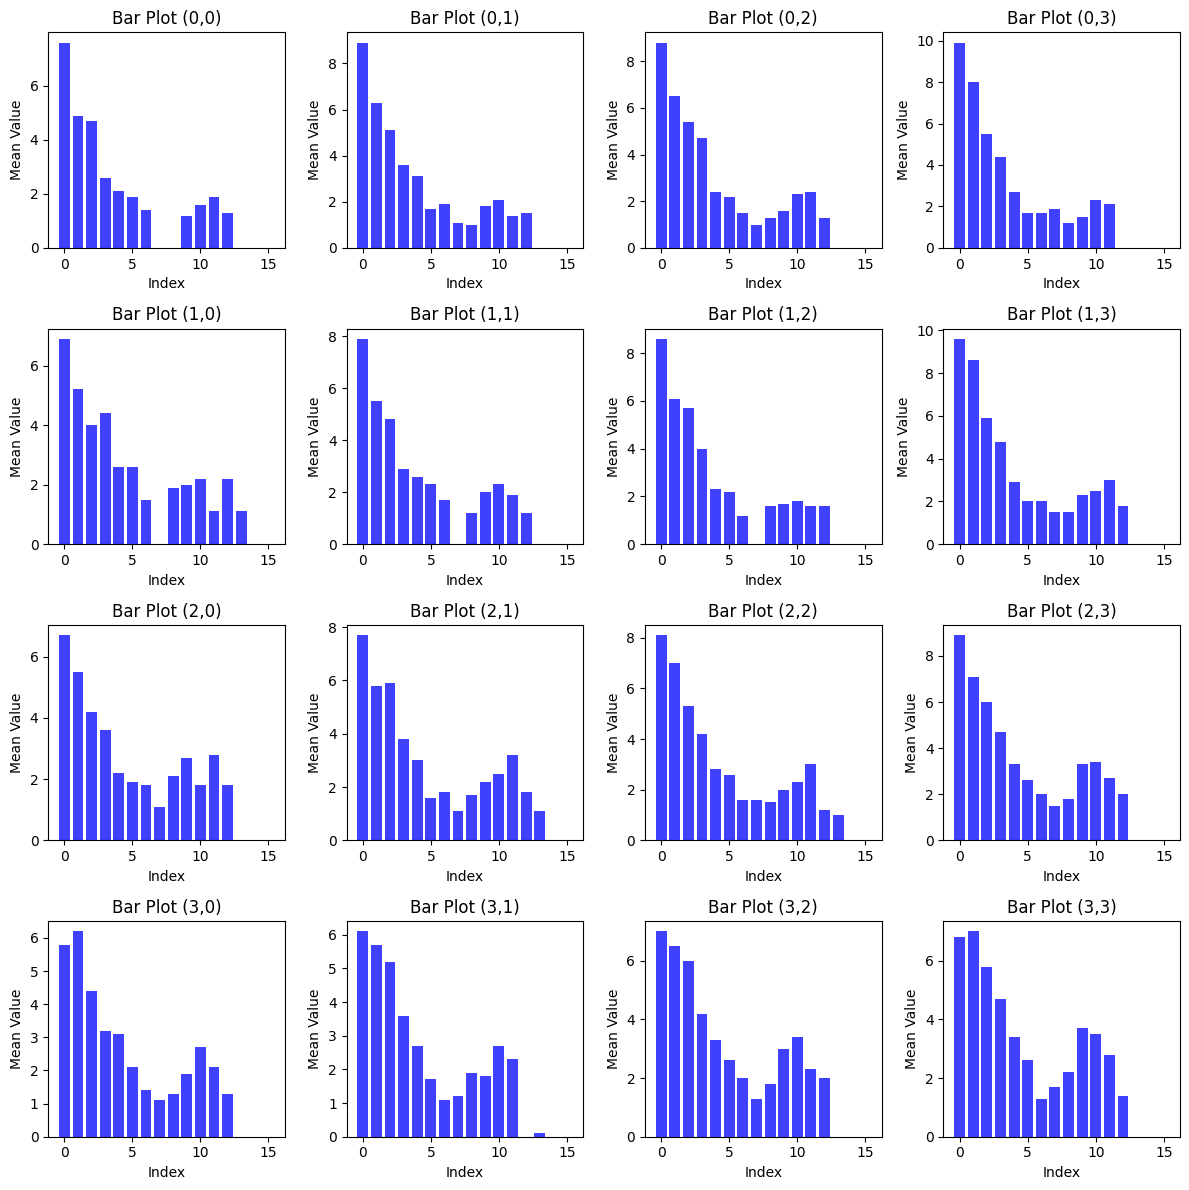

In [18]:
# Compute mean over the first dimension (n)
mean_tensor = dataset_1.raw_inputs[900]  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(16)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
        axes[i, j].bar(x, mean_tensor[i, j].numpy(), color='b', alpha=0.75)
        axes[i, j].set_title(f"Bar Plot ({i},{j})")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("Mean Value")
        # axes[i, j].set_yscale('log')

plt.tight_layout()
plt.show()

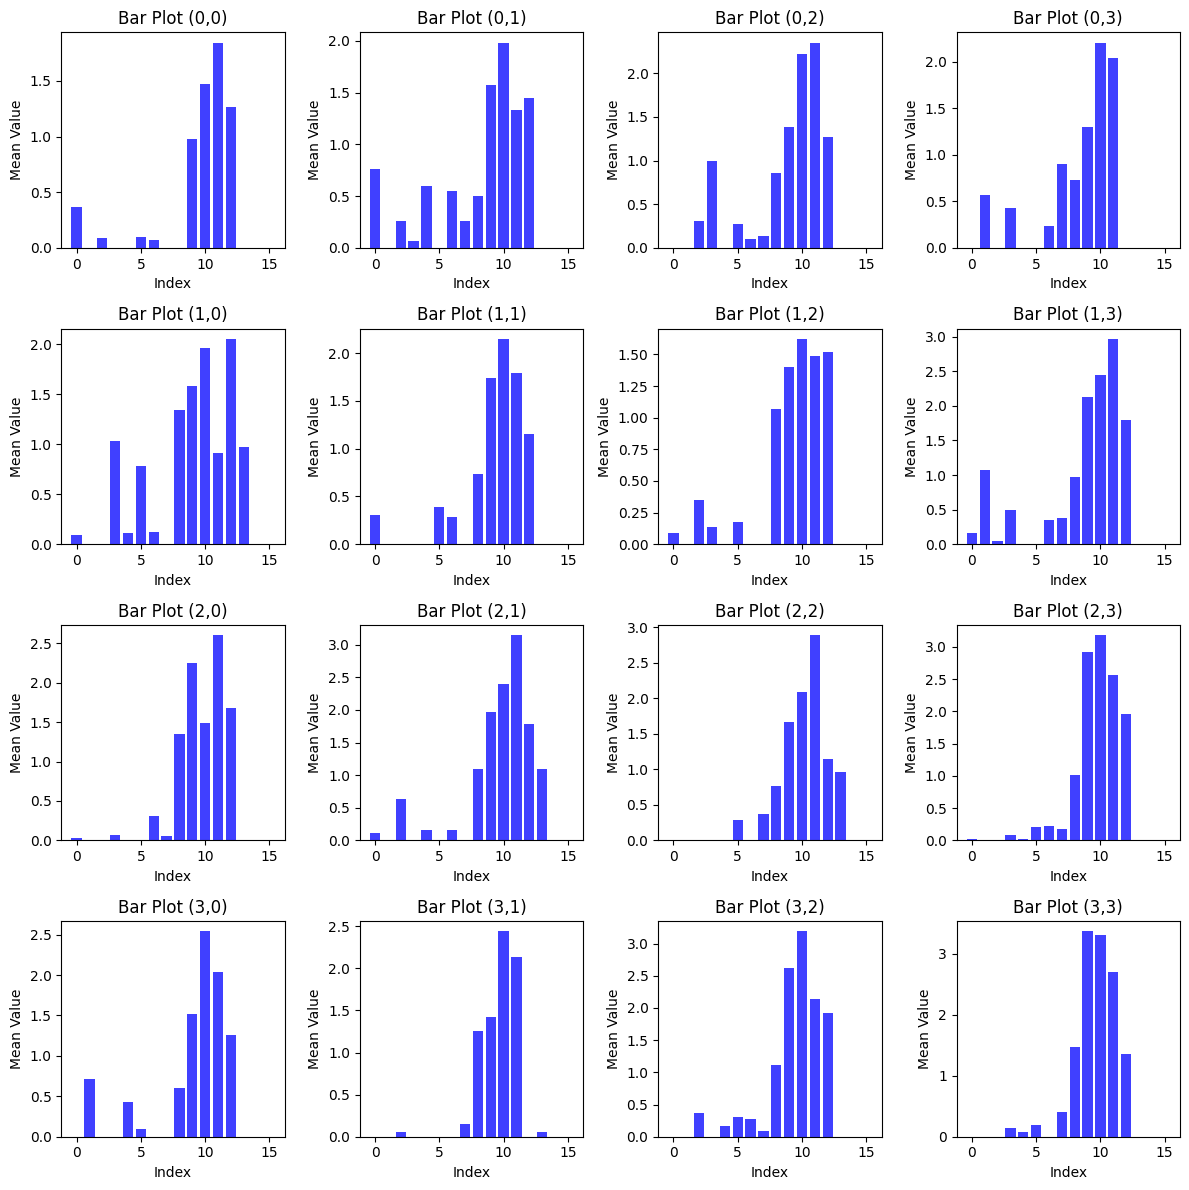

In [19]:
# Compute mean over the first dimension (n)
mean_tensor = dataset_1.inputs[900]  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(16)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
        axes[i, j].bar(x, mean_tensor[i, j].numpy(), color='b', alpha=0.75)
        axes[i, j].set_title(f"Bar Plot ({i},{j})")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("Mean Value")
        # axes[i, j].set_yscale('log')

plt.tight_layout()
plt.show()

In [20]:
dataset_first_bounce.raw_inputs = dataset_first_bounce.raw_inputs[3:]
dataset_first_bounce.inputs = dataset_first_bounce.inputs[3:]
dataset_first_bounce.invert()
dataset_1.invert()

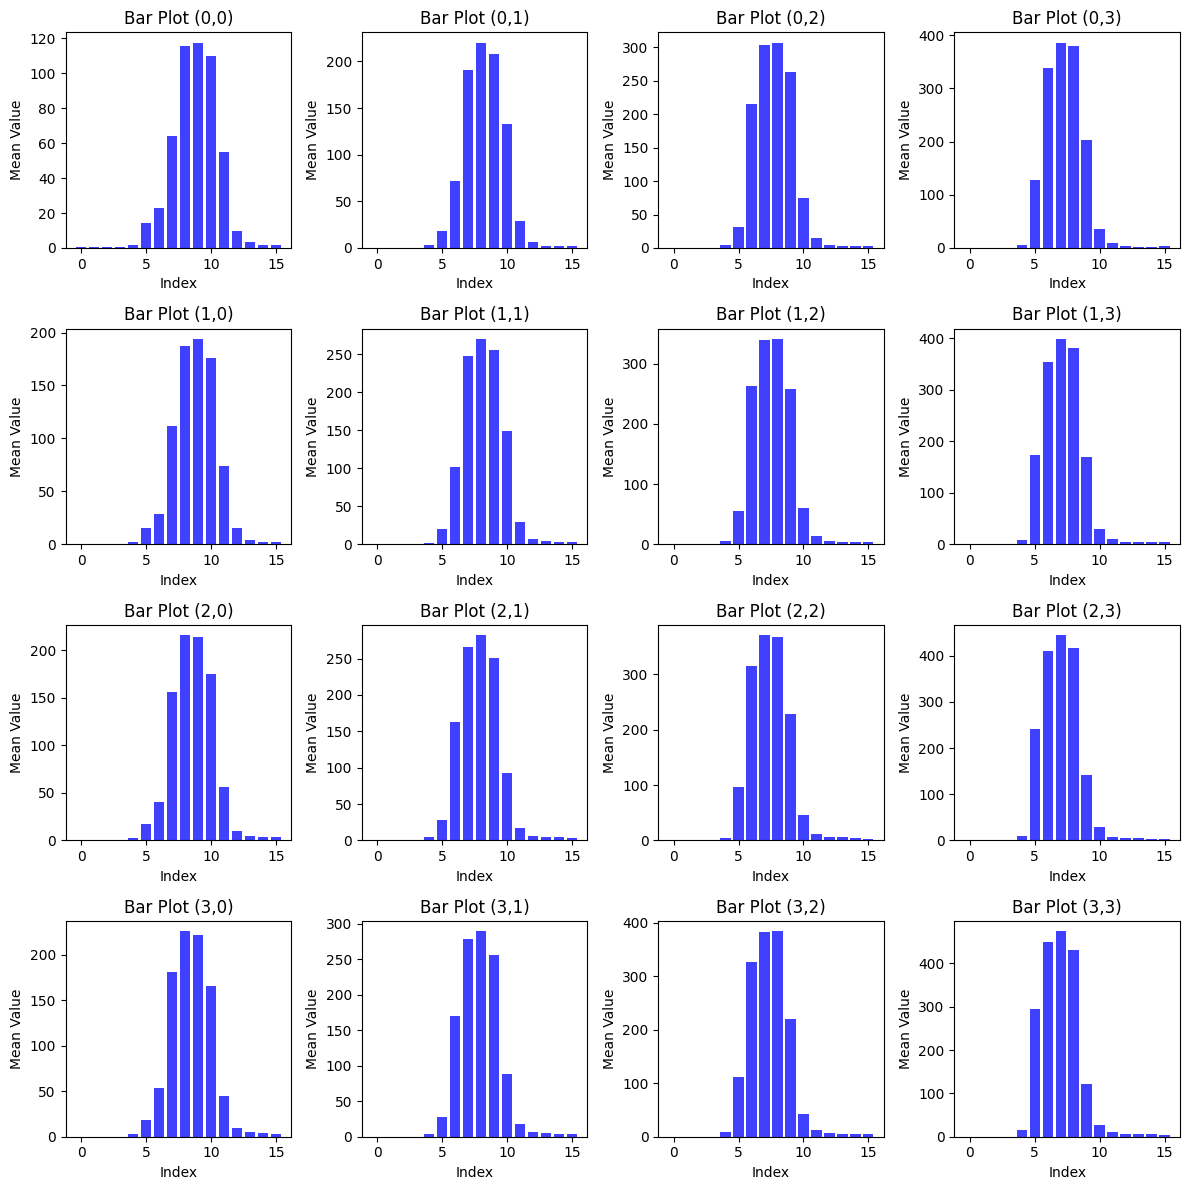

In [21]:
# Compute mean over the first dimension (n)
mean_tensor = dataset_first_bounce.inputs[2]  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(16)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
        axes[i, j].bar(x, mean_tensor[i, j].numpy(), color='b', alpha=0.75)
        axes[i, j].set_title(f"Bar Plot ({i},{j})")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("Mean Value")
        # axes[i, j].set_yscale('log')

plt.tight_layout()
plt.show()

In [22]:
print(len(dataset_debug))

234


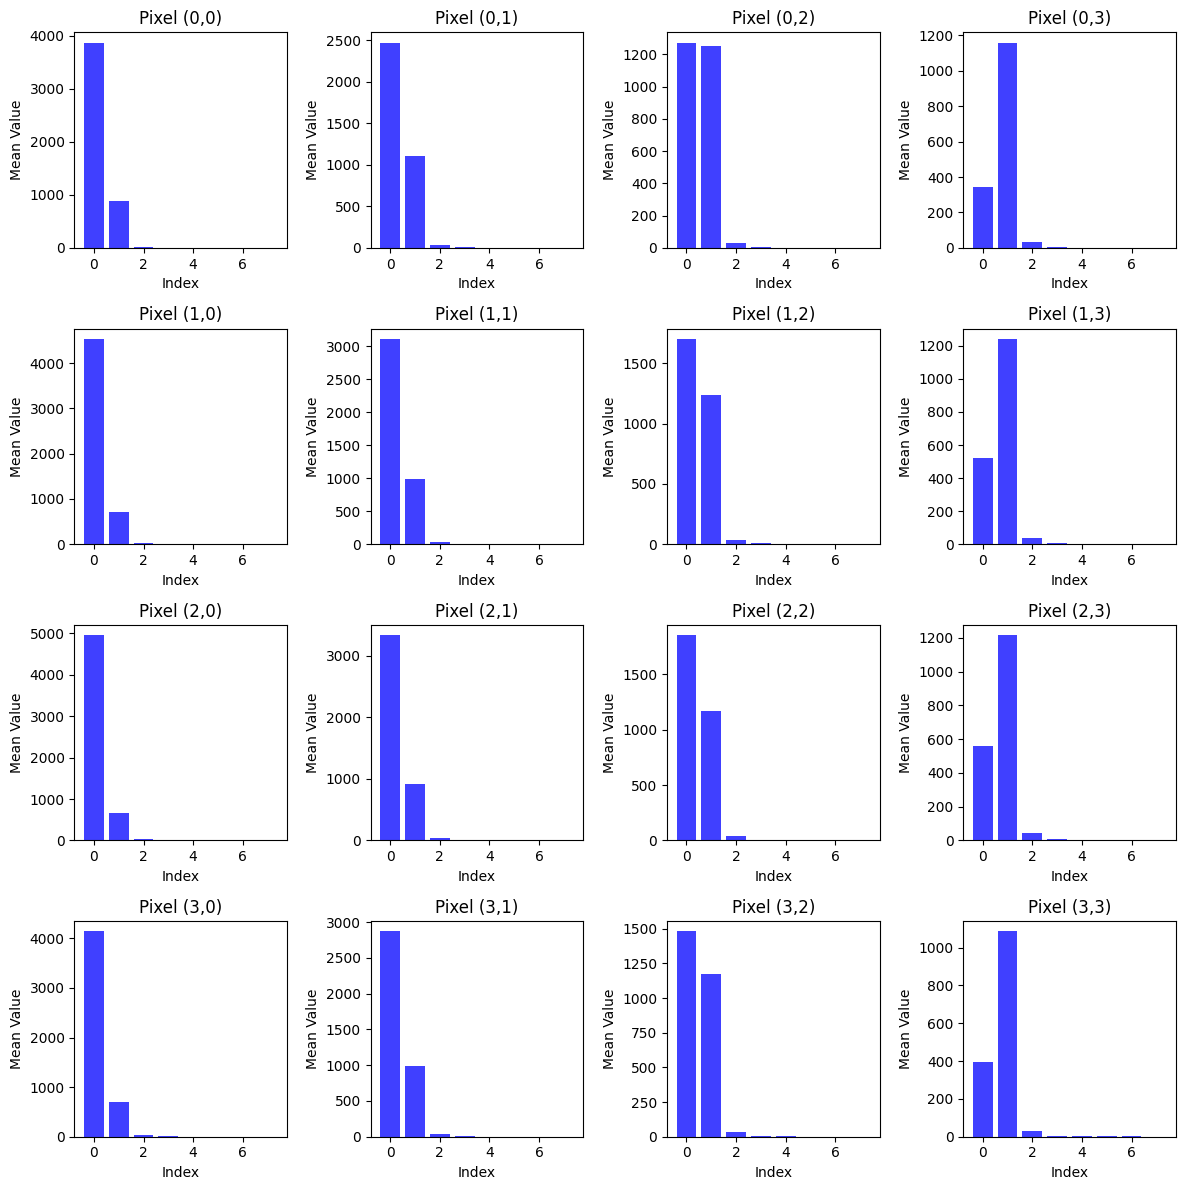

In [23]:
# Compute mean over the first dimension (n)
mean_tensor = dataset_debug.inputs[230]  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(8)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
        axes[i, j].bar(x, mean_tensor[i, j].numpy(), color='b', alpha=0.75)
        axes[i, j].set_title(f"Pixel ({i},{j})")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("Mean Value")
        # axes[i, j].set_yscale('log')

plt.tight_layout()
plt.show()

In [24]:
dataset_1.interpolate_bins(2)

In [25]:
dataset_1.raw_inputs.shape

torch.Size([1000, 8, 8, 16])

In [26]:
dataset_1.inputs.shape

torch.Size([1000, 8, 8, 32])

In [27]:
# relative to sensor at (0, 0, 0)
# (X, Y, Z) axes oriented with x right, y forward, z up
# sensor facing positive y
def extract_first_bounce_point_cloud(hists: np.ndarray, average: bool = True, cnh_start_bin: int = 0, interpolate_bins: int = 1) -> np.ndarray:
    # hists is of shape (n, width, height, bins)
    first_bounce_hists = hists.copy()
    if average:
        first_bounce_hists = first_bounce_hists.mean(axis=0, keepdims=True)
    
    n, H, W, B = first_bounce_hists.shape

    points = np.empty((n, H, W, 3))

    # precompute depths corresponding to each bin
    depths = np.arange(0, B).astype(np.float32)
    depths = depths * BIN_RESOLUTION + cnh_start_bin * MIN_RESOLUTION + BIN_RESOLUTION / 2

    for i in range(H):
        for j in range(W):
            for hist_num in range(n):
                bin_index = np.argmax(first_bounce_hists[hist_num, i, j, :])

                if interpolate_bins > 1:
                    # get weighted mean of interpolated bins, centered at bin_index (even number of bins uses next bin after bin_index)
                    included_bins = np.arange(-interpolate_bins // 2 + 1, interpolate_bins // 2 + 1)
                    included_bins = included_bins + bin_index
                    included_bins = np.clip(included_bins, 0, B - 1)
                    weights = first_bounce_hists[hist_num, i, j, included_bins]
                    weights = weights / np.sum(weights)
                    depth = np.sum(depths[included_bins] * weights)
                else:
                    # TODO: why / 2?
                    # assume point is in center of max bin
                    depth = bin_index * BIN_RESOLUTION + cnh_start_bin * MIN_RESOLUTION + BIN_RESOLUTION / 2
                # do d=1 computations
                dz = (2*i - H + 1) * math.tan(FOV_Y / 2 * math.pi / 180) / H
                dx = (2*j - W + 1) * math.tan(FOV_X / 2 * math.pi / 180) / W
                d = math.sqrt(depth ** 2 / (dx ** 2 + dz ** 2 + 1))
                X = dx * d
                Y = d
                Z = -1 * dz * d
                points[hist_num, i, j, :] = np.array([X, Y, Z])

    # output is of shape (n, H, W, 3), if average = True, n = 1
    return points



In [28]:
dataset_first_bounce.raw_inputs.shape

torch.Size([997, 8, 8, 16])

In [29]:
raw_hists = dataset_first_bounce.raw_inputs

all_pt_clouds = np.empty((0, 3))
for i in range(raw_hists.shape[0]):
    pt_clouds = extract_point_cloud_interpolated(
        dataset_first_bounce.raw_inputs[i].numpy(),
        1
    )
    all_pt_clouds = np.append(all_pt_clouds, pt_clouds, axis=0)

In [30]:
mean_pt_clouds = extract_point_cloud_interpolated(
    dataset_first_bounce.raw_inputs.mean(dim=0).numpy(),
    1
)

In [31]:
mean_adj_pt_clouds = extract_first_bounce_point_cloud(
    dataset_first_bounce.inputs.numpy(),
    average=True,
    cnh_start_bin=0,
    interpolate_bins=5
)

In [32]:
# pt_clouds = mean_pt_clouds
pt_clouds = mean_adj_pt_clouds

In [33]:
pt_clouds

array([[[[-0.22565925,  0.62261671,  0.22565925],
         [-0.1519197 ,  0.58682656,  0.21268758],
         [-0.08806545,  0.5669568 ,  0.20548605],
         [-0.02747964,  0.53073374,  0.19235748],
         [ 0.02668665,  0.51541814,  0.18680654],
         [ 0.07710838,  0.49641626,  0.17991955],
         [ 0.12477971,  0.48199178,  0.17469159],
         [ 0.16721562,  0.46136481,  0.16721562]],

        [[-0.23008586,  0.63483017,  0.16434704],
         [-0.15501326,  0.59877619,  0.15501326],
         [-0.08931438,  0.5749973 ,  0.1488573 ],
         [-0.02785339,  0.53795219,  0.13926693],
         [ 0.02728521,  0.52697863,  0.13642606],
         [ 0.07837706,  0.50458393,  0.13062844],
         [ 0.1266171 ,  0.48908917,  0.1266171 ],
         [ 0.17090892,  0.471555  ,  0.1220778 ]],

        [[-0.22241108,  0.61365468,  0.09531903],
         [-0.15312872,  0.59149668,  0.09187723],
         [-0.08688852,  0.55937985,  0.08688852],
         [-0.0279176 ,  0.53919245,  0.0837528

In [34]:
pt_clouds.shape

(1, 8, 8, 3)

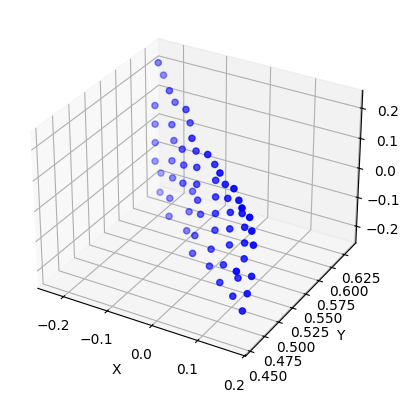

In [35]:
# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(pt_clouds[:, :, :, 0], pt_clouds[:, :, :, 1], pt_clouds[:, :, :, 2], c='b', marker='o')

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [36]:
from scipy.spatial import Delaunay

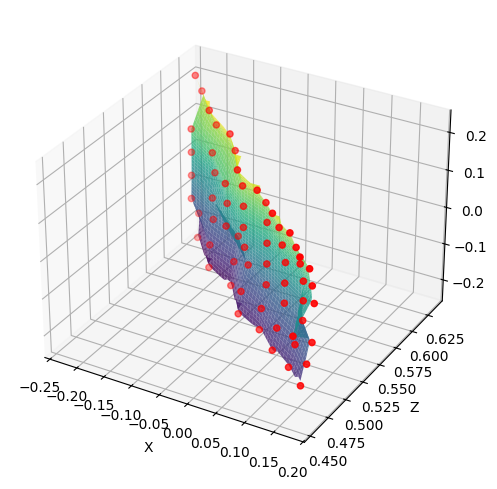

In [37]:
x = pt_clouds[:, :, :, 0].flatten()
y = pt_clouds[:, :, :, 1].flatten()
z = pt_clouds[:, :, :, 2].flatten()

# Stack points for Delaunay (only using x, z as independent variables)
points = np.column_stack((x, z))
tri = Delaunay(points)

# Create a grid for interpolation
xi, zi = np.meshgrid(np.linspace(min(x), max(x), 50), np.linspace(min(z), max(z), 50))
interp_points = np.c_[xi.ravel(), zi.ravel()]

# Find the simplex (triangle) each interpolation point belongs to
simplices = tri.find_simplex(interp_points)
valid = simplices >= 0  # Ignore points outside the convex hull

# Transform interpolation points to barycentric coordinates
T = tri.transform[simplices[valid], :2]  # Affine transformation matrices
b = np.einsum('ijk,ik->ij', T, interp_points[valid] - tri.transform[simplices[valid], 2])

# Add the last barycentric coordinate (1 - sum of the others)
bary_coords = np.c_[b, 1 - b.sum(axis=1)]

# Get indices of the triangle vertices
vert_indices = tri.simplices[simplices[valid]]

# Compute interpolated y-values using barycentric weights
y_interp = np.einsum('ij,ij->i', bary_coords, y[vert_indices])

# Fill in the grid with interpolated values
Yi = np.full(xi.shape, np.nan)
Yi.ravel()[valid] = y_interp

# Plot the interpolated surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, Yi, zi, cmap='viridis', edgecolor='none', alpha=0.8)
ax.scatter(x, y, z, c='r', marker='o')  # Plot original points

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")

plt.show()

In [38]:
from scipy.spatial import cKDTree


Text(0.5, 0, 'Z')

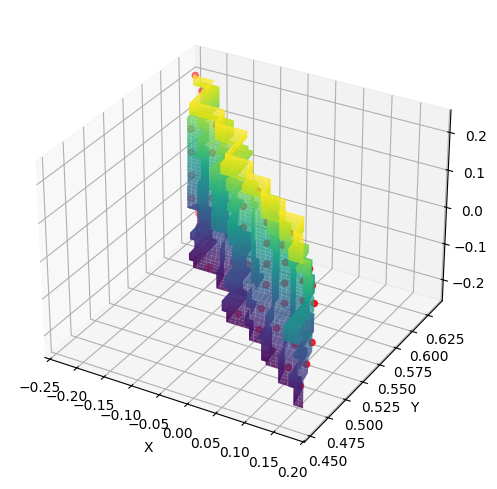

In [39]:
# Stack (x, z) for nearest-neighbor search
points = np.column_stack((x, z))
tree = cKDTree(points)  # Create KDTree for fast lookup

# Create a grid for interpolation
xi, zi = np.meshgrid(np.linspace(min(x), max(x), 50), np.linspace(min(z), max(z), 50))
interp_points = np.c_[xi.ravel(), zi.ravel()]  # Flattened grid points

# Find nearest neighbors
_, interp_indices = tree.query(interp_points)  # Find nearest points in original set
y_interp_nn = y[interp_indices]  # Assign nearest neighbor values

# Reshape interpolated values into grid
Yi_nn = y_interp_nn.reshape(xi.shape)

# Plot the nearest-neighbor interpolated surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, Yi_nn, zi, cmap='viridis', edgecolor='none', alpha=0.8)
ax.scatter(x, y, z, c='r', marker='o')  # Original points

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

In [40]:
# Nearest-neighbor interpolation setup
points = np.column_stack((x, z))
tree = cKDTree(points)

# Create interpolation grid
xi = np.linspace(min(x), max(x), 50)
zi = np.linspace(min(z), max(z), 50)
X, Z = np.meshgrid(xi, zi)
interp_points = np.c_[X.ravel(), Z.ravel()]

# Nearest neighbor interpolation
_, nn_indices = tree.query(interp_points)
Y_interp = y[nn_indices].reshape(X.shape)

# Create interactive plot with Plotly
fig = go.Figure()

# Interpolated surface
fig.add_trace(go.Surface(
    x=X, y=Y_interp, z=Z,
    colorscale='Viridis',
    opacity=0.8,
    name='Interpolated Surface'
))

# Original points
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=4, color='red'),
    name='Original Points'
))

# Customize layout
fig.update_layout(
    title='Nearest Neighbor Interpolation (Interactive)',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ),
    width=800,
    height=600,
    showlegend=True
)

fig.show()

In [41]:
pt_clouds_flattened = pt_clouds.reshape(pt_clouds.shape[0] * pt_clouds.shape[1] * pt_clouds.shape[2], pt_clouds.shape[3])

In [42]:
def plot_delaunay(pt_clouds_flattened):
    x = pt_clouds_flattened[:, 0]
    y = pt_clouds_flattened[:, 1]
    z = pt_clouds_flattened[:, 2]

    # Stack points for Delaunay (only using x, z as independent variables)
    points = np.column_stack((x, z))
    tri = Delaunay(points)

    # Create a grid for interpolation
    xi, zi = np.meshgrid(np.linspace(min(x), max(x), 50), np.linspace(min(z), max(z), 50))
    interp_points = np.c_[xi.ravel(), zi.ravel()]

    # Find the simplex (triangle) each interpolation point belongs to
    simplices = tri.find_simplex(interp_points)
    valid = simplices >= 0  # Ignore points outside the convex hull

    # Transform interpolation points to barycentric coordinates
    T = tri.transform[simplices[valid], :2]  # Affine transformation matrices
    b = np.einsum('ijk,ik->ij', T, interp_points[valid] - tri.transform[simplices[valid], 2])

    # Add the last barycentric coordinate (1 - sum of the others)
    bary_coords = np.c_[b, 1 - b.sum(axis=1)]

    # Get indices of the triangle vertices
    vert_indices = tri.simplices[simplices[valid]]

    # Compute interpolated y-values using barycentric weights
    y_interp = np.einsum('ij,ij->i', bary_coords, y[vert_indices])

    # Fill in the grid with interpolated values
    Yi = np.full(xi.shape, np.nan)
    Yi.ravel()[valid] = y_interp

    # Create interactive plot with Plotly
    fig = go.Figure()

    # Interpolated surface
    fig.add_trace(go.Surface(
        x=xi, y=Yi, z=zi,
        colorscale='Viridis',
        opacity=0.8,
        name='Interpolated Surface'
    ))

    # Original points
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=4, color='red'),
        name='Original Points'
    ))

    # Customize layout
    fig.update_layout(
        title='Delaunay Interpolation (Interactive)',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
        ),
        width=800,
        height=600,
        showlegend=True
    )

    fig.show()

In [43]:
def plot_points(pt_clouds_flattened):
    x = pt_clouds_flattened[:, 0]
    y = pt_clouds_flattened[:, 1]
    z = pt_clouds_flattened[:, 2]

    # Create interactive plot with Plotly
    fig = go.Figure()

    # Original points
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=4, color='red'),
        name='Original Points'
    ))

    # Step 1: Original ranges
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    z_min, z_max = np.min(z), np.max(z)

    # Step 2: Compute span and center for each axis
    x_span, x_mid = x_max - x_min, (x_max + x_min) / 2
    y_span, y_mid = y_max - y_min, (y_max + y_min) / 2
    z_span, z_mid = z_max - z_min, (z_max + z_min) / 2

    # Step 3: Determine the largest span
    max_span = max(x_span, y_span, z_span)
    half_span = max_span / 2

    # Step 4: Create new equal ranges centered on the original data
    x_range = [x_mid - half_span, x_mid + half_span]
    y_range = [y_mid - half_span, y_mid + half_span]
    z_range = [z_mid - half_span, z_mid + half_span]

    # Step 5: Apply to layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', range=x_range),
            yaxis=dict(title='Y', range=y_range),
            zaxis=dict(title='Z', range=z_range),
            aspectmode='manual',
            aspectratio=dict(x=1, y=1, z=1)
        ),
        width=800,
        height=600,
        showlegend=True
    )

    fig.show()

In [44]:
plot_delaunay(pt_clouds_flattened)

In [45]:
plot_points(pt_clouds_flattened)

In [46]:
def fit_plane_ransac(points, threshold=0.01, num_iterations=1000, min_inliers=10):
    best_plane = None
    best_inlier_mask = None
    max_inliers = 0
    N = points.shape[0]

    for _ in range(num_iterations):
        # Randomly sample 3 unique points
        idx = np.random.choice(N, 3, replace=False)
        p1, p2, p3 = points[idx]

        # Compute plane normal
        v1 = p2 - p1
        v2 = p3 - p1
        normal = np.cross(v1, v2)
        norm = np.linalg.norm(normal)
        if norm == 0:
            continue  # Degenerate case
        normal = normal / norm
        a, b, c = normal
        d = -np.dot(normal, p1)

        # Compute distances from all points to the plane
        distances = np.abs(points @ normal + d)

        # Inlier mask
        inlier_mask = distances < threshold
        num_inliers = np.sum(inlier_mask)

        # Save best plane
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_plane = (a, b, c, d)
            best_inlier_mask = inlier_mask

    if max_inliers < min_inliers:
        return None, None

    return best_plane, best_inlier_mask


def detect_multiple_planes(points, threshold=0.01, num_iterations=1000, min_inliers=10):
    points = np.copy(points)
    n_points = len(points)
    planes = []
    labels = -np.ones(n_points, dtype=int)  # All points start as unassigned
    remaining_mask = np.ones(n_points, dtype=bool)
    current_label = 0

    while np.sum(remaining_mask) >= min_inliers:
        active_points = points[remaining_mask]
        plane, inlier_mask = fit_plane_ransac(active_points, threshold, num_iterations, min_inliers)

        if inlier_mask is None or np.sum(inlier_mask) < min_inliers:
            break

        # Map inliers back to original indices
        inlier_indices = np.where(remaining_mask)[0][inlier_mask]
        labels[inlier_indices] = current_label
        planes.append(plane)
        remaining_mask[inlier_indices] = False
        current_label += 1

    return planes, labels

In [47]:
planes, labels = detect_multiple_planes(pt_clouds_flattened)

In [48]:
best_plane, best_inliers = fit_plane_ransac(pt_clouds_flattened)

In [49]:
planes

[(-0.3417523198489463,
  -0.9397869932848034,
  -0.002399818862423914,
  0.5032151864549017)]

In [50]:
best_plane

(-0.3457127998200255,
 -0.938329100784123,
 -0.004599854590985371,
 0.5021207234201085)

In [51]:
def plot_planes_plotly_with_surfaces(points, labels, planes, patch_size=0.2, resolution=10):
    fig = go.Figure()
    max_label = labels.max()
    colors = px.colors.qualitative.Set1

    # Plot each plane's inlier points
    for i in range(max_label + 1):
        mask = labels == i
        fig.add_trace(go.Scatter3d(
            x=points[mask, 0],
            y=points[mask, 1],
            z=points[mask, 2],
            mode='markers',
            marker=dict(size=3, color=colors[i % len(colors)]),
            name=f"Plane {i}"
        ))

        # Plane surface patch
        plane_points = points[mask]
        if plane_points.shape[0] >= 3:
            center = plane_points.mean(axis=0)
            a, b, c, d = planes[i]
            normal = np.array([a, b, c])
            # Find two orthogonal vectors in the plane
            v1 = np.cross(normal, np.array([0, 0, 1]) if not np.allclose(normal[:2], 0) else np.array([1, 0, 0]))
            v1 /= np.linalg.norm(v1)
            v2 = np.cross(normal, v1)
            v2 /= np.linalg.norm(v2)

            # Create a grid in the plane
            u = np.linspace(-patch_size, patch_size, resolution)
            v = np.linspace(-patch_size, patch_size, resolution)
            uu, vv = np.meshgrid(u, v)
            plane_patch = center + uu[..., None] * v1 + vv[..., None] * v2
            x, y, z = plane_patch[..., 0], plane_patch[..., 1], plane_patch[..., 2]

            fig.add_trace(go.Surface(
                x=x, y=y, z=z,
                showscale=False,
                opacity=0.5,
                colorscale=[[0, colors[i % len(colors)]], [1, colors[i % len(colors)]]],
                name=f"Surface {i}",
                hoverinfo='skip'
            ))

    # Plot outlier points
    outlier_mask = labels == -1
    if np.any(outlier_mask):
        fig.add_trace(go.Scatter3d(
            x=points[outlier_mask, 0],
            y=points[outlier_mask, 1],
            z=points[outlier_mask, 2],
            mode='markers',
            marker=dict(size=2, color='gray'),
            name="Outliers"
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=True
    )
    fig.show()

In [52]:
planes, labels = detect_multiple_planes(pt_clouds_flattened, threshold=0.1)
plot_planes_plotly_with_surfaces(pt_clouds_flattened, labels, planes)

In [53]:
print(planes)

[(-0.3002599484634435, -0.9510310217915937, -0.07337546550971581, 0.508461502302158)]


In [54]:
def project_point_to_plane(point, normal, d):
    """Project a 3D point onto a plane defined by normal and offset d."""
    distance = (np.dot(normal, point) + d)
    return point - distance * normal

In [55]:
def rotation_matrix_from_axis_angle(axis, angle):
    """
    Returns a 3x3 rotation matrix rotating by `angle` radians around `axis`.
    """
    axis = axis / np.linalg.norm(axis)
    x, y, z = axis
    c = np.cos(angle)
    s = np.sin(angle)
    C = 1 - c

    R = np.array([
        [c + x*x*C,     x*y*C - z*s, x*z*C + y*s],
        [y*x*C + z*s, c + y*y*C,     y*z*C - x*s],
        [z*x*C - y*s, y*z*C + x*s, c + z*z*C    ]
    ])
    return R

In [56]:
def rotation_matrix_from_vectors(v1, v2):
    """Find the rotation matrix that aligns v1 to v2."""
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    cross = np.cross(v1, v2)
    dot = np.dot(v1, v2)
    if np.isclose(dot, -1.0):  # 180 degree flip
        # Special case: rotate around any axis orthogonal to v1
        # prefer to rotate around z axis (turning)
        axis = np.array([0, 0, 1]) if not np.allclose(v1, [0, 0, 1]) else np.array([1, 0, 0])
        axis = axis - axis.dot(v1) * v1
        axis /= np.linalg.norm(axis)
        return rotation_matrix_from_axis_angle(axis, np.pi)
    elif np.isclose(dot, 1.0):
        return np.eye(3)
    skew = np.array([
        [0, -cross[2], cross[1]],
        [cross[2], 0, -cross[0]],
        [-cross[1], cross[0], 0]
    ])
    R = np.eye(3) + skew + skew @ skew * ((1 - dot) / (np.linalg.norm(cross)**2))

    print(R)
    return R


In [57]:
def plane_alignment_transform(points, plane):
    # Get homogeneous transformation matrix for setting plane to origin

    a, b, c, d = plane
    normal = np.array([a, b, c])

    # 1. Compute centroid of the point cloud
    center = np.mean(points, axis=0)
    
    # 2. Project that point onto the plane
    projected = project_point_to_plane(center, normal, d)

    # 3. Compute rotation to align normal with Z axis
    target = np.array([0, 1, 0])
    R = rotation_matrix_from_vectors(normal, target)

    # 4. Build 4×4 transformation matrix
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = -R @ projected  # move the projected point to the origin

    return T


In [58]:
T = plane_alignment_transform(pt_clouds_flattened, best_plane)
# points_h = np.hstack([pt_clouds_flattened, np.ones((pt_clouds_flattened.shape[0], 1))])  # shape (n, 4)
# transformed_points = (T @ points_h.T).T[:, :3]
points_h = np.concatenate([pt_clouds, np.ones((pt_clouds.shape[0], pt_clouds.shape[1], pt_clouds.shape[2], 1))], axis=-1)  # homogeneous coordinates
transformed_points = np.einsum("nhwc,cd->nhwd", points_h, T.T)[:, :, :, :3]

[[-0.93798601  0.3457128  -0.02578572]
 [-0.3457128  -0.9383291  -0.00459985]
 [-0.02578572  0.00459985  0.99965691]]


In [59]:
transformed_points_flattened = transformed_points.reshape(transformed_points.shape[0] * transformed_points.shape[1] * transformed_points.shape[2], transformed_points.shape[3])

In [60]:
plot_points(transformed_points_flattened)

In [61]:
camera_position = T[:3, 3]

In [62]:
camera_position

array([-0.19674936,  0.50212072, -0.0028273 ])

In [170]:
def backprojection_from_point_cloud(pt_clouds, 
                    camera_position,
                    voxel_boundaries,
                    voxel_counts,
                #    start_gate, 
                #    end_gate, 
                    # bin_width, 
                    hists, 
                    # voxel_params,
                    # xlim, 
                    # ylim,
                    # zlim,
                    # thresh = np.nan
                    cnh_start_bin: int = 0,
                    bin_resolution: int = BIN_RESOLUTION
                    ):
        """
        pt_clouds : np array of shape [n, h, w, 3]  
        # voxel_grid: [num_voxels, 3]
        voxel_boundaries: [[x_min, x_max], [y_min, y_max], [z_min, z_max]]
        voxel_counts: [x_count, y_count, z_count]
        # start_gate: scalar
        # end_gate  : scalar
        # bin_width : scalar
        hists     : np array of shape [n, h, w, num_bins]
        cnh_start_bin : scalar
        """
        # === reshape hists and point clouds === #
        # average point clouds by pixel if not already averaged
        pt_clouds = pt_clouds.mean(axis=0, keepdims=True)
        pt_clouds = pt_clouds.squeeze(axis=0)
        # shape: (h, w, 3)
        h = pt_clouds.shape[0]
        w = pt_clouds.shape[1]
        num_bins = hists.shape[3]

        # # === reshape hists and point clouds === #
        # hists = [hist.reshape(64, -1) for hist in hists]
        # pt_clouds = [pt_cloud.reshape(64, 3) for pt_cloud in pt_clouds]
        
        # === Extract voxel params === #
        # num_x, num_y, num_z = voxel_params[0:3]
        # num_voxels = voxel_grid.shape[0]

        # === Extract other parameters === #
        # num_hists = len(hists)
        # if np.isnan(thresh):
        #     thresh = bin_width * C

        # === Extract voxel grid === #
        # generate voxel grid
        num_x, num_y, num_z = voxel_counts
        x_min, x_max = voxel_boundaries[0]
        y_min, y_max = voxel_boundaries[1]
        z_min, z_max = voxel_boundaries[2]

        voxel_edges_x = np.linspace(x_min, x_max, num_x + 1)
        voxel_edges_y = np.linspace(y_min, y_max, num_y + 1)
        voxel_edges_z = np.linspace(z_min, z_max, num_z + 1)

        voxel_dimensions_x = voxel_edges_x[1] - voxel_edges_x[0]
        voxel_dimensions_y = voxel_edges_y[1] - voxel_edges_y[0]
        voxel_dimensions_z = voxel_edges_z[1] - voxel_edges_z[0]

        voxel_centers_x = voxel_edges_x[:-1] + voxel_dimensions_x / 2
        voxel_centers_y = voxel_edges_y[:-1] + voxel_dimensions_y / 2
        voxel_centers_z = voxel_edges_z[:-1] + voxel_dimensions_z / 2

        voxel_grid = np.array(np.meshgrid(voxel_centers_x, voxel_centers_y, voxel_centers_z, indexing='ij'))
        # dimension (3, num_x, num_y, num_z)
        # === Backprojection === #
        # calculate voxel distances to first bounce in each dimension (h, w, 3, num_x, num_y, num_z)
        pt_clouds_voxel_product = np.expand_dims(pt_clouds, axis=(3, 4, 5))
        pt_clouds_broadcasted = np.broadcast_to(pt_clouds_voxel_product, (h, w, 3, num_x, num_y, num_z))
        voxel_grid_product = np.expand_dims(voxel_grid, axis=(0, 1))
        voxel_grid_broadcasted = np.broadcast_to(voxel_grid_product, (h, w, 3, num_x, num_y, num_z))
        voxel_distances_to_first_bounce = pt_clouds_broadcasted - voxel_grid_broadcasted
        # (h, w, 3, num_x, num_y, num_z)

        # convert to euclidean distances
        voxel_distances_to_first_bounce = np.linalg.norm(voxel_distances_to_first_bounce, axis=2)
        # (h, w, num_x, num_y, num_z)
        print("voxel_distances_to_first_bounce.shape: ", voxel_distances_to_first_bounce.shape)
        
        # calculate histogram bin distances
        start_distance = cnh_start_bin * MIN_RESOLUTION
        bin_depth = np.linspace(start_distance + bin_resolution / 2, start_distance + num_bins * bin_resolution - bin_resolution / 2, num_bins)
        bin_depth_by_pixel = np.tile(bin_depth, (h, w, 1))
        print("bin_depth_by_pixel.shape: ", bin_depth_by_pixel.shape)
        
        # recalculate first bounce distances from point clouds
        first_bounce_distances = np.linalg.norm(pt_clouds - camera_position, axis=2, keepdims=True)
        print("first_bounce_distances.shape: ", first_bounce_distances.shape)
        
        # shift histogram bin distances to first bounce perspective
        bin_depth_from_first_bounce = bin_depth_by_pixel - first_bounce_distances
        print("bin_depth_from_first_bounce.shape: ", bin_depth_from_first_bounce.shape)
        
        # calculate distance differences between histogram bin distances and voxel distances
        bin_depth_from_first_bounce_broadcasted = np.expand_dims(bin_depth_from_first_bounce, axis=(3, 4, 5))
        bin_depth_from_first_bounce_broadcasted = np.broadcast_to(bin_depth_from_first_bounce_broadcasted, (h, w, num_bins, num_x, num_y, num_z))
        voxel_distances_to_first_bounce_broadcasted = np.expand_dims(voxel_distances_to_first_bounce, axis=(2))
        voxel_distances_to_first_bounce_broadcasted = np.broadcast_to(voxel_distances_to_first_bounce_broadcasted, (h, w, num_bins, num_x, num_y, num_z))
        print("bin_depth_from_first_bounce_broadcasted.shape: ", bin_depth_from_first_bounce_broadcasted.shape)
        print("voxel_distances_to_first_bounce_broadcasted.shape: ", voxel_distances_to_first_bounce_broadcasted.shape)
        
        distance_diffs = np.abs(bin_depth_from_first_bounce_broadcasted - voxel_distances_to_first_bounce_broadcasted)
        print("distance_diffs.shape: ", distance_diffs.shape)
        
        # calculate weights
        distance_threshold = BIN_RESOLUTION
        weights = distance_diffs < distance_threshold
        epsilon = 1e-6
        # weights = bin_resolution ** 2 / ((5 * distance_diffs + epsilon) ** 2)
        # clamp weights to 1
        weights = np.clip(weights, 0, 1)

        # normalize weights
        # weights = weights / np.sum(weights, axis=(3, 4, 5), keepdims=True)
        # print("weights.shape: ", weights.shape)
        # (h, w, num_bins, num_x, num_y, num_z)

        # calculate histogram contributions to voxels
        hist_contributions = np.einsum("nhwb,hwbxyz->nxyz", hists, weights)
        print("hist_contributions.shape: ", hist_contributions.shape)
        # (num_hists, num_x, num_y, num_z)

        hists_base = np.sum(weights, axis=(0, 1, 2))
        hists_base[hists_base == 0] = epsilon

        # # === Determine plotting === #
        # x_tick_labels = np.linspace(0, num_x-1, 3)
        # y_tick_labels = np.linspace(0, num_y-1, 3)
        # z_tick_labels = np.linspace(0, num_z-1, 3)

        # x_tick_vals = np.flip(np.linspace(xlim[0], xlim[1], 3))
        # y_tick_vals = np.flip(np.linspace(ylim[0], ylim[1], 3))
        # z_tick_vals = np.linspace(zlim[0], zlim[1], 3)

        # axis_labels = [x_tick_labels, y_tick_labels, z_tick_labels]
        # axis_vals = [x_tick_vals, y_tick_vals, z_tick_vals]

        # return hist_contributions - hists_base, voxel_grid
        return hist_contributions, voxel_grid
        # return hists_base[np.newaxis, :], voxel_grid



In [171]:
hists_third_bounce = dataset_1.inputs

In [172]:
hists_third_bounce.shape

torch.Size([1000, 8, 8, 32])

In [185]:
# hist_contributions, voxel_grid = backprojection_from_point_cloud(
#     pt_clouds,
#     voxel_boundaries=((-1.5, 0.5), (-0.5, 1.5), (-1.0, 1.0)),
#     voxel_counts=(30, 30, 30),
#     hists=hists_third_bounce,
#     cnh_start_bin=24
# )
hist_contributions, voxel_grid = backprojection_from_point_cloud(
    transformed_points,
    camera_position,
    voxel_boundaries=((0.0, 1.0), (0.2, 1.2), (-0.5, 0.5)),
    voxel_counts=(25, 25, 25),
    hists=hists_third_bounce,
    cnh_start_bin=24,
    bin_resolution=BIN_RESOLUTION / 2
)

voxel_distances_to_first_bounce.shape:  (8, 8, 25, 25, 25)
bin_depth_by_pixel.shape:  (8, 8, 32)
first_bounce_distances.shape:  (8, 8, 1)
bin_depth_from_first_bounce.shape:  (8, 8, 32)
bin_depth_from_first_bounce_broadcasted.shape:  (8, 8, 32, 25, 25, 25)
voxel_distances_to_first_bounce_broadcasted.shape:  (8, 8, 32, 25, 25, 25)
distance_diffs.shape:  (8, 8, 32, 25, 25, 25)
hist_contributions.shape:  (1000, 25, 25, 25)


In [186]:
exp_contributions = np.exp(hist_contributions)

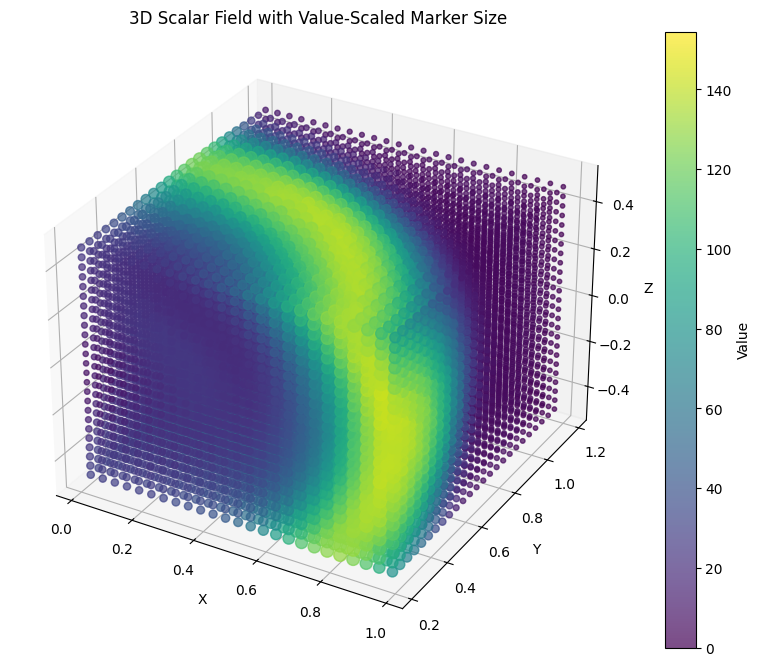

In [187]:
# Get grid
X, Y, Z = voxel_grid

# Sample data, replace with your actual (x, y, z)-shaped data
data = hist_contributions[0]

# Flatten for plotting
Xf, Yf, Zf, Df = X.flatten(), Y.flatten(), Z.flatten(), data.flatten()

# Normalize data for sizing (scale to between 10 and 100, for example)
Df_min, Df_max = Df.min(), Df.max()
sizes = 10 + 90 * (Df - Df_min) / (Df_max - Df_min)  # Scale to range [10, 100]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Xf, Yf, Zf, c=Df, s=sizes, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Value')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("3D Scalar Field with Value-Scaled Marker Size")
plt.show()

In [188]:
data_index = 300
# Get grid
X, Y, Z = voxel_grid

# data = hist_contributions[data_index]
data = hist_contributions[data_index:data_index+5].mean(axis=0)
label = dataset_1.targets[data_index]
print("Label: ", label)

# Flatten for plotting
Xf, Yf, Zf, Df = X.flatten(), Y.flatten(), Z.flatten(), data.flatten()

# Create interactive 3D volume plot
fig = go.Figure(data=go.Volume(
    x=Xf,
    y=Yf,
    z=Zf,
    value=Df,
    isomin=Df.min(), isomax=Df.max(),
    opacity=0.1,      # low opacity so interiors are visible
    surface_count=20, # number of iso-surfaces to render
    colorscale='Viridis',
))

fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
    aspectmode='cube'
    ),
    height=600,
    width=1000
)
fig.show()

Label:  tensor([11.6667, 42.0000])


In [189]:
data_index = 20

data = hist_contributions[data_index]
label = dataset_1.targets[data_index]
print(label)

x_slice = np.max(data, axis=0)
y_slice = np.max(data, axis=1)
z_slice = np.max(data, axis=2)

# Create subplot figure
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=("YZ (Max over X)", "XZ (Max over Y)", "XY (Max over Z)"))

# Add heatmaps
fig.add_trace(go.Heatmap(z=x_slice, colorscale='Viridis', colorbar=dict(title='Value')), row=1, col=1)
fig.add_trace(go.Heatmap(z=y_slice, colorscale='Viridis', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=z_slice, colorscale='Viridis', showscale=False), row=1, col=3)

# Update layout
fig.update_layout(
    title='Max Projections of 3D Volume',
    height=400,
    width=1000,
)

fig.show()

tensor([0.0000, 9.3333])


In [190]:
data_index = 700

data = hist_contributions[data_index]
label = dataset_1.targets[data_index]
print(label)

x_slice = np.max(data, axis=0)
y_slice = np.max(data, axis=1)
z_slice = np.max(data, axis=2)

# Create subplot figure
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=("YZ (Max over X)", "XZ (Max over Y)", "XY (Max over Z)"))

# Add heatmaps
fig.add_trace(go.Heatmap(z=x_slice, colorscale='Viridis', colorbar=dict(title='Value')), row=1, col=1)
fig.add_trace(go.Heatmap(z=y_slice, colorscale='Viridis', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=z_slice, colorscale='Viridis', showscale=False), row=1, col=3)

# Update layout
fig.update_layout(
    title='Max Projections of 3D Volume',
    height=400,
    width=1000,
)

fig.show()

tensor([27.2222, 42.0000])


In [191]:
# Get data
data_indices = [0, 50, 100, 150]
volumes = [hist_contributions[i] for i in data_indices]
labels = [dataset_1.targets[i] for i in data_indices]

# Compute XY projections (max over Z axis)
xy_projections = [vol.max(axis=2) for vol in volumes]

# Set global min/max for consistent color scale
vmin = min(proj.min() for proj in xy_projections)
vmax = max(proj.max() for proj in xy_projections)

# Create 2x2 subplot
fig = sp.make_subplots(
    rows=2, cols=2,
    subplot_titles=[f'Label: {labels[i]}' for i in range(4)],
    horizontal_spacing=0.05,
    vertical_spacing=0.1
)

# Add heatmaps with individual color scales, no colorbars
for i, proj in enumerate(xy_projections):
    row = i // 2 + 1
    col = i % 2 + 1

    fig.add_trace(
        go.Heatmap(
            z=proj,
            colorscale='Viridis',
            showscale=False  # Hide colorbar
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title='XY Max Projections (Max over Z) for 4 Volumes',
    height=800,
    width=800,
    margin=dict(r=80)  # Ensure room for the colorbar
)

fig.show()

In [192]:
# Get data
data_indices = [0, 50, 100, 150]
volumes = [np.log(exp_contributions[i]) for i in data_indices]
labels = [dataset_1.targets[i] for i in data_indices]

# Compute XY projections (max over Z axis)
xy_projections = [vol.max(axis=2) for vol in volumes]

# Set global min/max for consistent color scale
vmin = min(proj.min() for proj in xy_projections)
vmax = max(proj.max() for proj in xy_projections)

# Create 2x2 subplot
fig = sp.make_subplots(
    rows=2, cols=2,
    subplot_titles=[f'Label: {labels[i]}' for i in range(4)],
    horizontal_spacing=0.05,
    vertical_spacing=0.1
)

# Add heatmaps with individual color scales, no colorbars
for i, proj in enumerate(xy_projections):
    row = i // 2 + 1
    col = i % 2 + 1

    fig.add_trace(
        go.Heatmap(
            z=proj,
            colorscale='Viridis',
            showscale=False  # Hide colorbar
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title='XY Max Projections (Max over Z) for 4 Volumes',
    height=800,
    width=800,
    margin=dict(r=80)  # Ensure room for the colorbar
)

fig.show()

In [217]:
data_index = 0

data = hist_contributions[data_index:data_index+10].mean(axis=0)
label = dataset_1.targets[data_index]
print(label)

x_slice = np.max(data, axis=0)
y_slice = np.max(data, axis=1)
z_slice = np.max(data, axis=2)

# Create subplot figure
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=("YZ (Max over X)", "XZ (Max over Y)", "XY (Max over Z)"))

# Add heatmaps
fig.add_trace(go.Heatmap(z=x_slice, colorscale='Viridis', colorbar=dict(title='Value')), row=1, col=1)
fig.add_trace(go.Heatmap(z=y_slice, colorscale='Viridis', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=z_slice, colorscale='Viridis', showscale=False), row=1, col=3)

# Update layout
fig.update_layout(
    title='Max Projections of 3D Volume',
    height=400,
    width=1000,
)

fig.update_layout(
    xaxis1=dict(title='Y'),
    yaxis1=dict(title='Z'),
    xaxis2=dict(title='X'),
    yaxis2=dict(title='Z'),
    xaxis3=dict(title='X'),
    yaxis3=dict(title='Y')
)

fig.show()

tensor([0., 0.])


In [233]:
data_index = 0

# data = hist_contributions[data_index:data_index+5].mean(axis=0)
data = hist_contributions[data_index]
label = dataset_1.targets[data_index]
print(label)

x_slice = np.max(data, axis=0)
y_slice = np.max(data, axis=1)
z_slice = np.max(data, axis=2)

# Create subplot figure
fig = sp.make_subplots(rows=1, cols=3, horizontal_spacing=0.1,
    subplot_titles=("YZ (Max over X)", "XZ (Max over Y)", "XY (Max over Z)"))

# Add heatmaps
fig.add_trace(go.Heatmap(z=x_slice.T, colorscale='Viridis', colorbar=dict(title='Value')), row=1, col=1)
fig.add_trace(go.Heatmap(z=y_slice.T, colorscale='Viridis', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=z_slice.T, colorscale='Viridis', showscale=False), row=1, col=3)

# Update layout
fig.update_layout(
    title=f'Max Projections of Voxel Values, Location A, Gantry Position: ({label[0]:.1f}, {label[1]:.1f})',
    height=400,
    width=1000,
)

# Define your custom units, e.g., every 5 seconds
custom_tickvals = list(range(0, 25, 5))
custom_ticktext_x = [f"{(val*0.04 + 0):.1f}" for val in custom_tickvals]
custom_ticktext_y = [f"{(val*0.04 + 0.2):.1f}" for val in custom_tickvals]
custom_ticktext_z = [f"{(val*0.04 - 0.5):.1f}" for val in custom_tickvals]

fig.update_layout(
    xaxis1=dict(title='Y', tickvals=custom_tickvals, ticktext=custom_ticktext_y),
    yaxis1=dict(title='Z', tickvals=custom_tickvals, ticktext=custom_ticktext_z),
    xaxis2=dict(title='X', tickvals=custom_tickvals, ticktext=custom_ticktext_x),
    yaxis2=dict(title='Z', tickvals=custom_tickvals, ticktext=custom_ticktext_z),
    xaxis3=dict(title='X', tickvals=custom_tickvals, ticktext=custom_ticktext_x),
    yaxis3=dict(title='Y', tickvals=custom_tickvals, ticktext=custom_ticktext_y)
)

fig.show()

tensor([0., 0.])


In [234]:
data_index = 800

# data = hist_contributions[data_index:data_index+5].mean(axis=0)
data = hist_contributions[data_index]
label = dataset_1.targets[data_index]
print(label)

x_slice = np.max(data, axis=0)
y_slice = np.max(data, axis=1)
z_slice = np.max(data, axis=2)

# Create subplot figure
fig = sp.make_subplots(rows=1, cols=3, horizontal_spacing=0.1,
    subplot_titles=("YZ (Max over X)", "XZ (Max over Y)", "XY (Max over Z)"))

# Add heatmaps
fig.add_trace(go.Heatmap(z=x_slice.T, colorscale='Viridis', colorbar=dict(title='Value')), row=1, col=1)
fig.add_trace(go.Heatmap(z=y_slice.T, colorscale='Viridis', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=z_slice.T, colorscale='Viridis', showscale=False), row=1, col=3)

# Update layout
fig.update_layout(
    title=f'Max Projections of Voxel Values, Location B, Gantry Position: ({label[0]:.1f}, {label[1]:.1f})',
    height=400,
    width=1000,
)

# Define your custom units, e.g., every 5 seconds
custom_tickvals = list(range(0, 25, 5))
custom_ticktext_x = [f"{(val*0.04 + 0):.1f}" for val in custom_tickvals]
custom_ticktext_y = [f"{(val*0.04 + 0.2):.1f}" for val in custom_tickvals]
custom_ticktext_z = [f"{(val*0.04 - 0.5):.1f}" for val in custom_tickvals]

fig.update_layout(
    xaxis1=dict(title='Y', tickvals=custom_tickvals, ticktext=custom_ticktext_y),
    yaxis1=dict(title='Z', tickvals=custom_tickvals, ticktext=custom_ticktext_z),
    xaxis2=dict(title='X', tickvals=custom_tickvals, ticktext=custom_ticktext_x),
    yaxis2=dict(title='Z', tickvals=custom_tickvals, ticktext=custom_ticktext_z),
    xaxis3=dict(title='X', tickvals=custom_tickvals, ticktext=custom_ticktext_x),
    yaxis3=dict(title='Y', tickvals=custom_tickvals, ticktext=custom_ticktext_y)
)

fig.show()

tensor([31.1111,  0.0000])


In [235]:
data_index = 890

# data = hist_contributions[data_index:data_index+5].mean(axis=0)
data = hist_contributions[data_index]
label = dataset_1.targets[data_index]
print(label)

x_slice = np.max(data, axis=0)
y_slice = np.max(data, axis=1)
z_slice = np.max(data, axis=2)

# Create subplot figure
fig = sp.make_subplots(rows=1, cols=3, horizontal_spacing=0.1,
    subplot_titles=("YZ (Max over X)", "XZ (Max over Y)", "XY (Max over Z)"))

# Add heatmaps
fig.add_trace(go.Heatmap(z=x_slice.T, colorscale='Viridis', colorbar=dict(title='Value')), row=1, col=1)
fig.add_trace(go.Heatmap(z=y_slice.T, colorscale='Viridis', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=z_slice.T, colorscale='Viridis', showscale=False), row=1, col=3)

# Update layout
fig.update_layout(
    title=f'Max Projections of Voxel Values, Location C, Gantry Position: ({label[0]:.1f}, {label[1]:.1f})',
    height=400,
    width=1000,
)

# Define your custom units, e.g., every 5 seconds
custom_tickvals = list(range(0, 25, 5))
custom_ticktext_x = [f"{(val*0.04 + 0):.1f}" for val in custom_tickvals]
custom_ticktext_y = [f"{(val*0.04 + 0.2):.1f}" for val in custom_tickvals]
custom_ticktext_z = [f"{(val*0.04 - 0.5):.1f}" for val in custom_tickvals]

fig.update_layout(
    xaxis1=dict(title='Y', tickvals=custom_tickvals, ticktext=custom_ticktext_y),
    yaxis1=dict(title='Z', tickvals=custom_tickvals, ticktext=custom_ticktext_z),
    xaxis2=dict(title='X', tickvals=custom_tickvals, ticktext=custom_ticktext_x),
    yaxis2=dict(title='Z', tickvals=custom_tickvals, ticktext=custom_ticktext_z),
    xaxis3=dict(title='X', tickvals=custom_tickvals, ticktext=custom_ticktext_x),
    yaxis3=dict(title='Y', tickvals=custom_tickvals, ticktext=custom_ticktext_y)
)

fig.show()

tensor([31.1111, 42.0000])


In [236]:
data_index = 90

# data = hist_contributions[data_index:data_index+5].mean(axis=0)
data = hist_contributions[data_index]
label = dataset_1.targets[data_index]
print(label)

x_slice = np.max(data, axis=0)
y_slice = np.max(data, axis=1)
z_slice = np.max(data, axis=2)

# Create subplot figure
fig = sp.make_subplots(rows=1, cols=3, horizontal_spacing=0.1,
    subplot_titles=("YZ (Max over X)", "XZ (Max over Y)", "XY (Max over Z)"))

# Add heatmaps
fig.add_trace(go.Heatmap(z=x_slice.T, colorscale='Viridis', colorbar=dict(title='Value')), row=1, col=1)
fig.add_trace(go.Heatmap(z=y_slice.T, colorscale='Viridis', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=z_slice.T, colorscale='Viridis', showscale=False), row=1, col=3)

# Update layout
fig.update_layout(
    title=f'Max Projections of Voxel Values, Location D, Gantry Position: ({label[0]:.1f}, {label[1]:.1f})',
    height=400,
    width=1000,
)

# Define your custom units, e.g., every 5 seconds
custom_tickvals = list(range(0, 25, 5))
custom_ticktext_x = [f"{(val*0.04 + 0):.1f}" for val in custom_tickvals]
custom_ticktext_y = [f"{(val*0.04 + 0.2):.1f}" for val in custom_tickvals]
custom_ticktext_z = [f"{(val*0.04 - 0.5):.1f}" for val in custom_tickvals]

fig.update_layout(
    xaxis1=dict(title='Y', tickvals=custom_tickvals, ticktext=custom_ticktext_y),
    yaxis1=dict(title='Z', tickvals=custom_tickvals, ticktext=custom_ticktext_z),
    xaxis2=dict(title='X', tickvals=custom_tickvals, ticktext=custom_ticktext_x),
    yaxis2=dict(title='Z', tickvals=custom_tickvals, ticktext=custom_ticktext_z),
    xaxis3=dict(title='X', tickvals=custom_tickvals, ticktext=custom_ticktext_x),
    yaxis3=dict(title='Y', tickvals=custom_tickvals, ticktext=custom_ticktext_y)
)

fig.show()

tensor([ 0., 42.])
